In [1]:
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
import cv2
from functions import *
from scipy.ndimage import affine_transform
from function_week_3 import*

Note: you may need to restart the kernel to use updated packages.


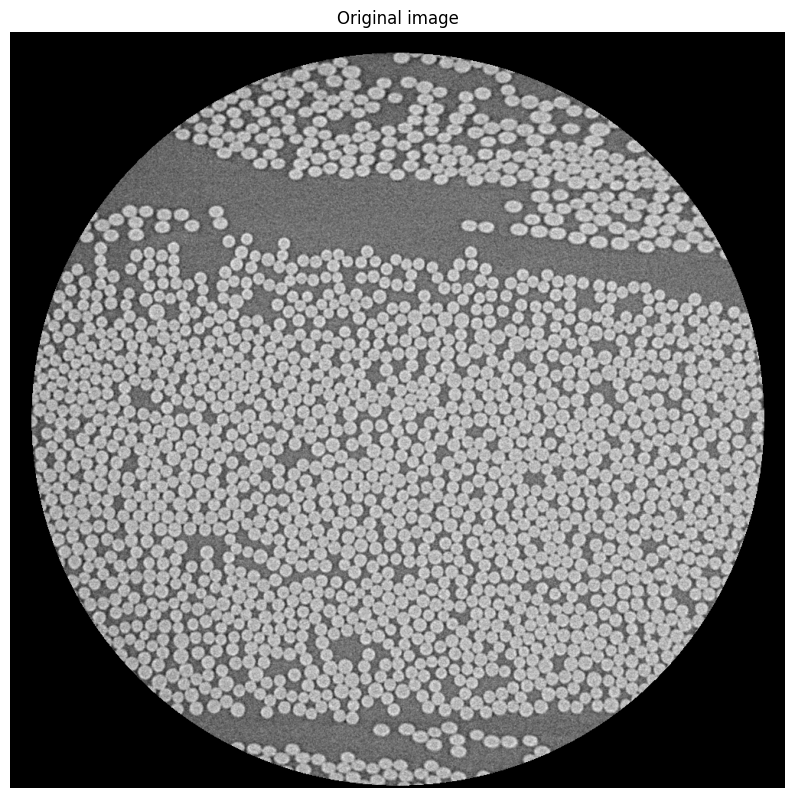

In [2]:
# load the iamge 

image_1 = get_gray_image('data/CT_lab_high_res.png')
image_2 = get_gray_image('data/CT_lab_high_res.png')


visualize_the_image(image=image_1)

In [2]:
def transform_image(t, s, theta, image, indexes):
    # Create a 2D rotation matrix for the angle theta (in radians).
    # The rotation matrix R rotates points counterclockwise.
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    
    # Reshape the translation vector to a column vector.
    # This is necessary to horizontally stack it with the rotation matrix.
    t = t.reshape(-1, 1)
    
    # Combine the rotation matrix and translation vector into a single affine transformation matrix.
    # np.hstack stacks R and t to produce a matrix of shape (2, 3) that encodes both rotation and translation.
    transformation_matrix = np.hstack([R, t])
    
    # Apply the affine transformation to the input image.
    # The function affine_transform from scipy.ndimage uses the transformation matrix to
    # map the output coordinates back to the input image, thus applying rotation and translation.
    image_transformed = affine_transform(image, transformation_matrix)
    
    # Scale the transformed image by multiplying its pixel values by the scaling factor 's'.
    image_scaled = s * image_transformed
    
    # Crop the scaled image using the provided indexes.
    # The 'indexes' tuple determines the start and end indices for both the rows and columns.
    # For instance, if indexes is (100, 600), the function crops the image from row 100 to 599 and column 100 to 599.
    cropped_image = image_scaled[indexes[0]:indexes[1], indexes[0]:indexes[1]]
    
    # Return the final processed image after rotation, translation, scaling, and cropping.
    return cropped_image

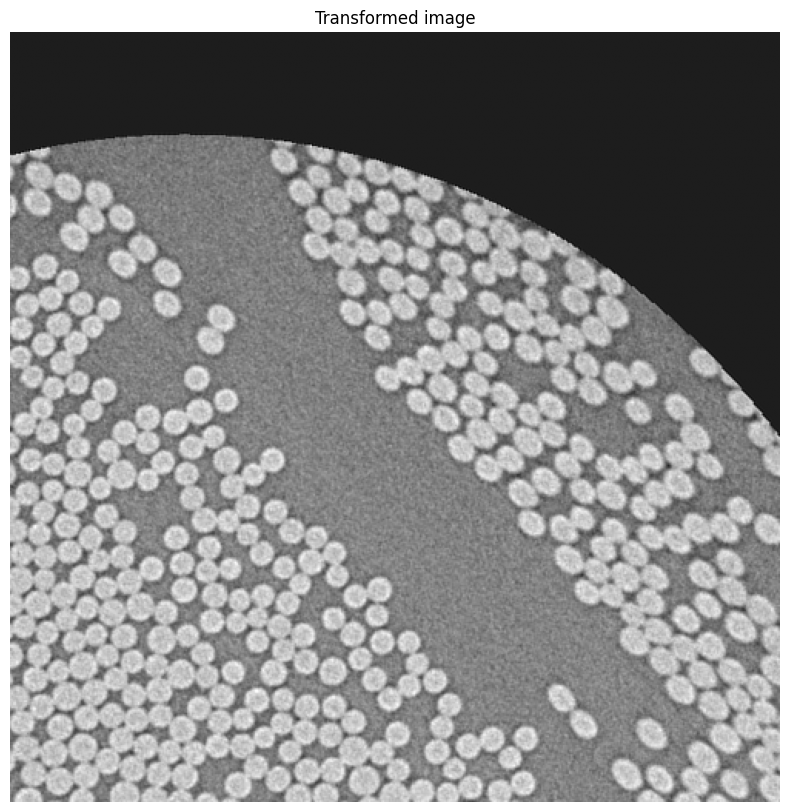

In [4]:
t = np.array([200, -100])
theta = np.pi / 4
s = 1
indexes = (100, 600)

image_2 = transform_image(t, s,theta, image_2, indexes )



visualize_the_image(image_2, 'Transformed image')
# convert image to greyscale 

In [ ]:
def locate_features(image_1, image_2):
    image_1 = cv2.cvtColor((image_1 * 255).astype(np.uint8), cv2.IMREAD_GRAYSCALE)
    image_2 = cv2.cvtColor((image_2 * 255).astype(np.uint8), cv2.IMREAD_GRAYSCALE)

    # Initialize the sift detectoor
    sift = cv2.SIFT_create()

        # detect keypoints and descripors with the sift detector
    keypoints1, descriptiors1 = sift.detectAndCompute(image_1, None)
    keypoints2, descriptiors2 = sift.detectAndCompute(image_2, None)



        # Draw the keypoints on the images with rich keypoints (which is keypoints with size and orientation)
    image1_with_kp = cv2.drawKeypoints(image_1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.
    image2_with_kp = cv2.drawKeypoints(image_2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.


    visualize_the_image(image1_with_kp, 'Original iamge with keypoints')
    visualize_the_image(image2_with_kp, 'Transformed iamge with keypoints')

    # Initialize the Open CV matcher - I use the Brute-Force matcher with L2 Norm 
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)



    # find k-Nearest Neighbours 
    # for each descriptor in the original image, find the two nearest descriptors in the transformed image 
    matches = bf.knnMatch(descriptiors1, descriptiors2, k=2)

    good_match = []
    # loop through the coordinates of a original (m) and transformed (n)
    # to access the distance use .distance 

    for m, n in matches: 
        #print(m.distance)
        #print(n.distance)
        #print(f"Original image distance {m.distance}")
        #print(f"Transformed distance {n.distance}")
        #print(f"The 0.6 Lowe criterion of the transformed image {0.6 * n.distance}")
        #print(f"Determine if good match or not {m.distance < 0.6 * n.distance}")
        if m.distance < 0.6 * n.distance:
            good_match.append(m)
    print(f"Number of good matches found {len(good_match)}")

    matched_img = cv2.drawMatches(image_1, keypoints1, image_2, keypoints2, good_match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.title("Matched Keypoints using SIFT and Lowe's Ratio Test")
    plt.imshow(matched_img)
    plt.axis('off')
    plt.show()
        #From yjr list of good matches (obtained using Lowe’s ratio test), each match object contains two indices:
    #queryIdx: Index of the keypoint in image1.
    #trainIdx: Index of the keypoint in image2.
    #Use these indices to extract the (x, y) coordinates from the keypoints of both images.
    #This gives you two corresponding sets of points: one from image1 (p_set) and one from image2 (q_set).

    p_set = np.array([keypoints1[m.queryIdx].pt for m in good_match])
    q_set = np.array([keypoints2[m.trainIdx].pt for m in good_match])

    # Optional: print the number of matching points
    print("Number of matching points:", len(p_set))


        # compute the uniform scale factor 

    s_prime = compute_scale(p_set, q_set)

    print(rf"The value of s' = {s_prime} the original value of s = {s}")


    R_hat = covariance_matrix(p_set, q_set)

    print(f"The value of R_hat is {R_hat} the original value of theta = {theta}")


    t_prime = translation(p_set, q_set, R_hat, s_prime)

    print(f"The value of t' = {t_prime} the original value of t = {t}")



        # Optional: print the number of matching points
    print("Number of matching points:", len(p_set))

    # Step 6: Compute the transformation parameters using your functions

    # Compute the uniform scale factor
    s = compute_scale(p_set, q_set)
    print("Computed scale:", s)

    # Compute the rotation matrix
    R = covariance_matrix(p_set, q_set)
    print("Computed rotation matrix:\n", R)

    # Compute the translation vector
    t = translation(p_set, q_set, R, s)
    print("Computed translation vector:", t)

    # Transform all keypoints from image1 using the computed transformation
    transformed_points = [transform_pt(p, s, R, t) for p in p_set]

    # Convert to numpy array for easier manipulation if needed
    transformed_points = np.array(transformed_points)

    # (Optional) Visualization: plot the transformed keypoints and actual keypoints from image2
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGRA2RGB))
    plt.scatter(p_set[:, 0], p_set[:, 1], marker='o', color='red', label='Original Points')
    plt.title("Image 1 Keypoints")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGRA2RGB))
    plt.scatter(q_set[:, 0], q_set[:, 1], marker='o', color='blue', label='Matched Points')
    plt.scatter(transformed_points[:, 0], transformed_points[:, 1], marker='x', color='green', label='Transformed Points')
    plt.title("Image 2: Actual vs Transformed")
    plt.legend()
    plt.show()


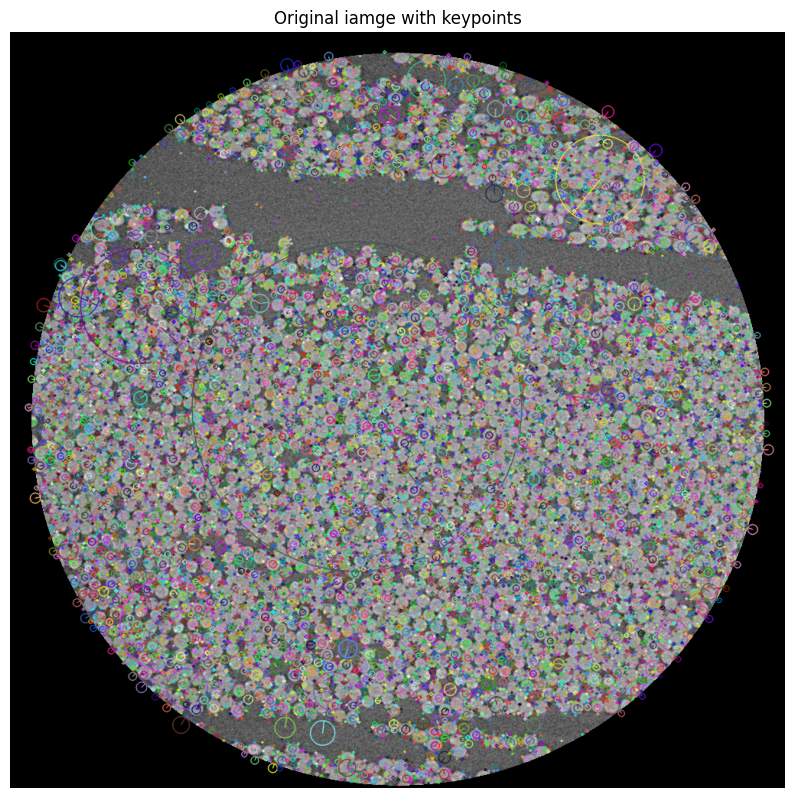

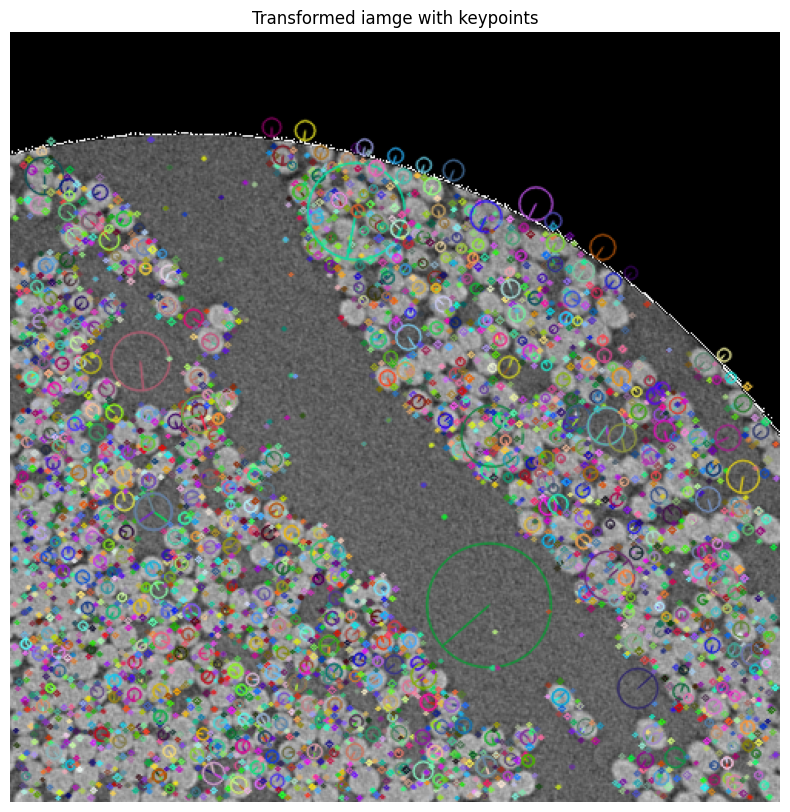

Number of good matches found 2768


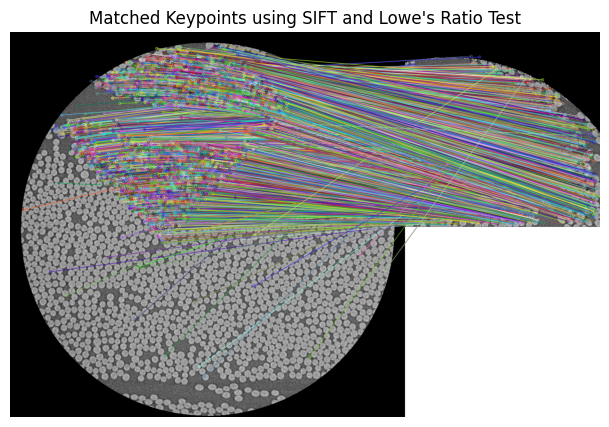

Number of matching points: 2768
The value of s' = 0.9873963880860078 the original value of s = 1
The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  0.9999999999999998
[[-0.99917866 -0.04052157]
 [-0.04052157  0.99917866]]
The value of R_hat is [[ 0.7022882  -0.71189275]
 [ 0.71189275  0.7022882 ]] the original value of theta = 0.7853981633974483
The value of t' = [ 118.13508536 -167.49382931] the original value of t = [ 200 -100]
Number of matching points: 2768
Computed scale: 0.9873963880860078
The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  0.9999999999999998
[[-0.99917866 -0.04052157]
 [-0.04052157  0.99917866]]
Computed rotation matrix:
 [[ 0.7022882  -0.71189275]
 [ 0.71189275  0.7022882 ]]
Computed translation vector: [ 118.13508536 -167.49382931]


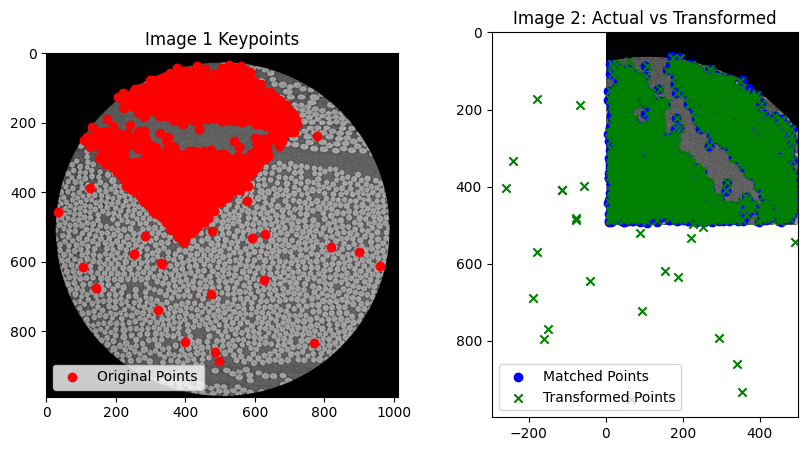

In [6]:
locate_features(image_1, image_2, s, t, theta)

In [45]:
quiz_1 = skimage.io.imread('data/quiz_image_1.png')
quiz_2 = skimage.io.imread('data/quiz_image_2.png')


In [46]:
quiz_1 = cv2.cvtColor((quiz_1 * 255).astype(np.uint8), cv2.IMREAD_GRAYSCALE)
quiz_2 = cv2.cvtColor((quiz_2 * 255).astype(np.uint8), cv2.IMREAD_GRAYSCALE)

In [47]:
sift = cv2.SIFT_create()

        # detect keypoints and descripors with the sift detector
keypoints1, descriptiors1 = sift.detectAndCompute(quiz_1, None)
keypoints2, descriptiors2 = sift.detectAndCompute(quiz_2, None)

In [48]:
print(len(keypoints2))

6331


In [49]:
image1_with_kp = cv2.drawKeypoints(quiz_1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.
image2_with_kp = cv2.drawKeypoints(quiz_2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.


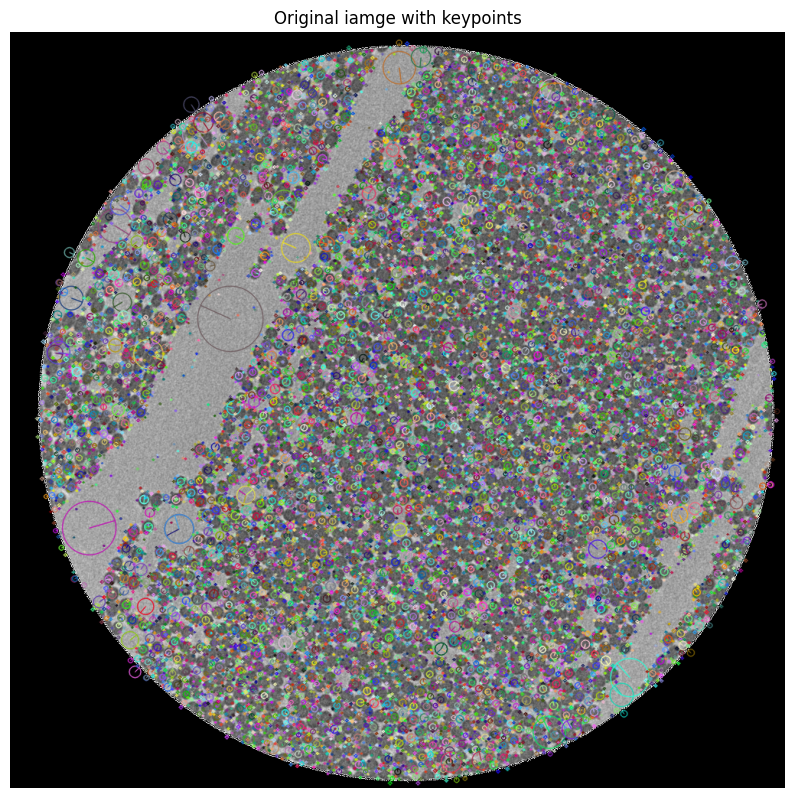

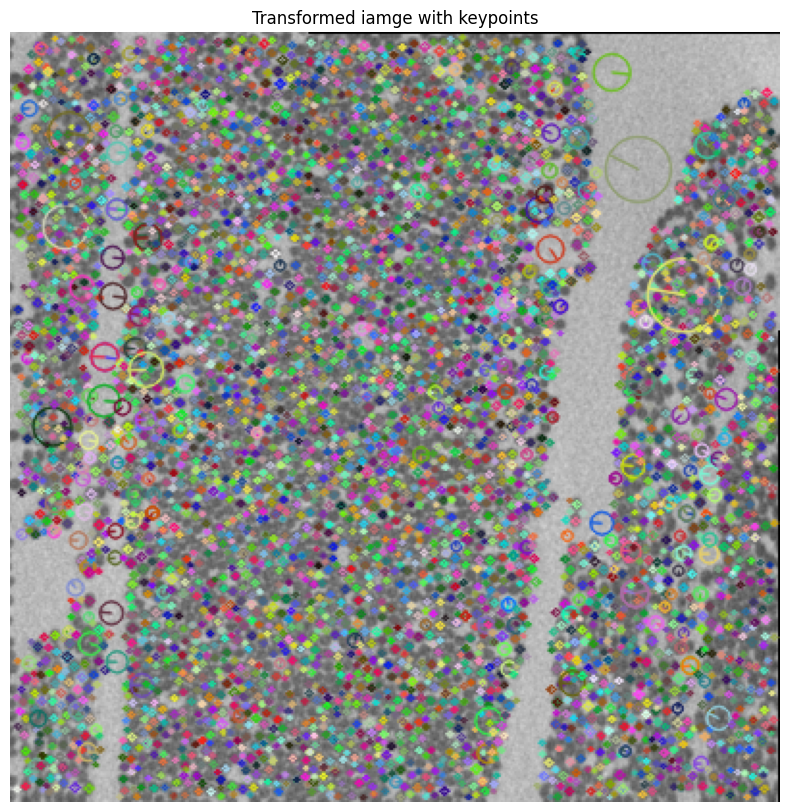

In [50]:
visualize_the_image(image1_with_kp, 'Original iamge with keypoints')
visualize_the_image(image2_with_kp, 'Transformed iamge with keypoints')

In [51]:


    # Initialize the Open CV matcher - I use the Brute-Force matcher with L2 Norm 
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

In [52]:
# find k-Nearest Neighbours 
# for each descriptor in the original image, find the two nearest descriptors in the transformed image 
matches = bf.knnMatch(descriptiors1, descriptiors2, k=2)

good_match = []
# loop through the coordinates of a original (m) and transformed (n)
# to access the distance use .distance 

for m, n in matches: 
    #print(m.distance)
    #print(n.distance)
    #print(f"Original image distance {m.distance}")
    #print(f"Transformed distance {n.distance}")
    #print(f"The 0.6 Lowe criterion of the transformed image {0.6 * n.distance}")
    #print(f"Determine if good match or not {m.distance < 0.6 * n.distance}")
    if m.distance < 0.5 * n.distance:
        good_match.append(m)
print(f"Number of good matches found {len(good_match)}")

Number of good matches found 375


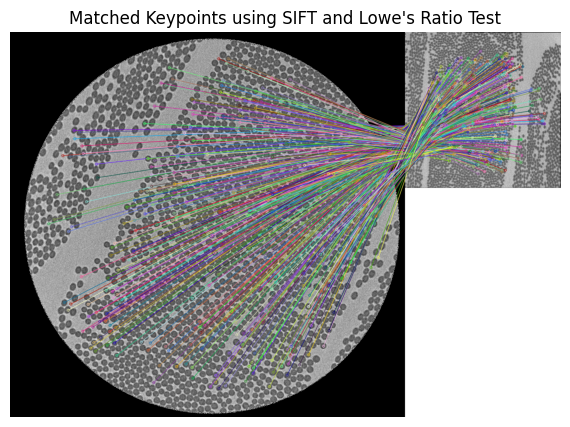

Number of matching points: 375


In [53]:
matched_img = cv2.drawMatches(quiz_1, keypoints1, quiz_2, keypoints2, good_match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 5))
plt.title("Matched Keypoints using SIFT and Lowe's Ratio Test")
plt.imshow(matched_img)
plt.axis('off')
plt.show()
        #From yjr list of good matches (obtained using Lowe’s ratio test), each match object contains two indices:
    #queryIdx: Index of the keypoint in image1.
    #trainIdx: Index of the keypoint in image2.
    #Use these indices to extract the (x, y) coordinates from the keypoints of both images.
    #This gives you two corresponding sets of points: one from image1 (p_set) and one from image2 (q_set).

p_set = np.array([keypoints1[m.queryIdx].pt for m in good_match])
q_set = np.array([keypoints2[m.trainIdx].pt for m in good_match])

# Optional: print the number of matching points
print("Number of matching points:", len(p_set))

In [54]:
s_prime = compute_scale(p_set, q_set)

print(rf"The value of s' = {s_prime}")


R_hat = covariance_matrix(p_set, q_set)

print(f"The value of R_hat is {R_hat}")


t_prime = translation(p_set, q_set, R_hat, s_prime)

print(f"The value of t' = {t_prime}")



t_prime = np.linalg.norm(t_prime)

print(t_prime)

The value of s' = 0.368474242074275
The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  1.0000000000000007
[[-0.03828797  0.99926675]
 [ 0.99926675  0.03828797]]
The value of R_hat is [[-0.91985868 -0.39224994]
 [ 0.39224994 -0.91985868]]
The value of t' = [448.46912112 300.30281034]
539.7280152966855


In [55]:
data = create_entry(keypoint_number = len(good_match), scale = s_prime, translation_length = t_prime)

name_of_file = "quiz.txt"

save_to_file(name_of_file, data)

print(f"Data saved to {name_of_file}")

Data saved to quiz.txt


In [ ]:
atches, matched_img